

```
# Tiene formato de código
```

# First trial with more memory.

In [ ]:
#Load the modules
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt

import gc #garbage collection, we need to save all the RAM we can

In [ ]:
# We are combining another piece of code to extract directly the files here
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fid = drive.ListFile({'q':"title='dataset.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('dataset.zip')

In [ ]:
!unzip dataset.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: train/9a85638e7d8a29bc02f0de3f937827ce98a79471.tif  
  inflating: __MACOSX/train/._9a85638e7d8a29bc02f0de3f937827ce98a79471.tif  
  inflating: train/898d82a450ac7adc097e956b9eaf7b4ae7286983.tif  
  inflating: __MACOSX/train/._898d82a450ac7adc097e956b9eaf7b4ae7286983.tif  
  inflating: train/b2bc0daec2c8c7a154bd0e17f2c79fb851650d73.tif  
  inflating: __MACOSX/train/._b2bc0daec2c8c7a154bd0e17f2c79fb851650d73.tif  
  inflating: train/1da035090ecbced39c2cf209e67d76c364d7588e.tif  
  inflating: __MACOSX/train/._1da035090ecbced39c2cf209e67d76c364d7588e.tif  
  inflating: train/7baf79b7d55c7552393071f4fd98b8f50f40c16a.tif  
  inflating: __MACOSX/train/._7baf79b7d55c7552393071f4fd98b8f50f40c16a.tif  
  inflating: train/1048fd5f36b296f7b76bb5ffbc41c3a19e0da1df.tif  
  inflating: __MACOSX/train/._1048fd5f36b296f7b76bb5ffbc41c3a19e0da1df.tif  
  inflating: train/50d24de9d3dbc78113a08e8dee9009819beffe10.tif  
  inflating: __

In [ ]:
#set paths to training and test data
#path = "MACOSX/" #adapt this path, when running locally
train_path = 'train/'
test_path = 'test/'

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[1].split(".")[0]) # keep only the file names in 'id'
labels = pd.read_csv("train_labels.csv") # read the provided labels
df = df.merge(labels, on = "id") # merge labels and filepaths
df.head(3) # print the first three entrys

,path,id,label
0,train/faa45f6f53e06c186281e1ea1ebf6e4e4aa46285...,faa45f6f53e06c186281e1ea1ebf6e4e4aa46285,0
1,train/bd0cfde4a005704c9f2d9f24d1ba28d0c0481f7c...,bd0cfde4a005704c9f2d9f24d1ba28d0c0481f7c,1
2,train/dbeb2614b7fda51975699367c9304b7189b2816f...,dbeb2614b7fda51975699367c9304b7189b2816f,0



Taken from complete-beginner-s-guide-eda-keras-lb-0-93

In [ ]:
from tqdm import tqdm

def load_data(N, df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N, 96, 96, 3], dtype=np.uint8)
    # convert the labels to a numpy array too
    y = np.squeeze(df[['label']].to_numpy())[0:N]

    '''Because as_matrix is deprecated I changed it for another df[['label]].to_numpy'''

    # read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])

    return X, y

In [ ]:
# Load 10k images
N=1000
X,y = load_data(N=N,df=df) 

 75%|███████▍  | 749/1000 [00:00<00:00, 2868.01it/s]


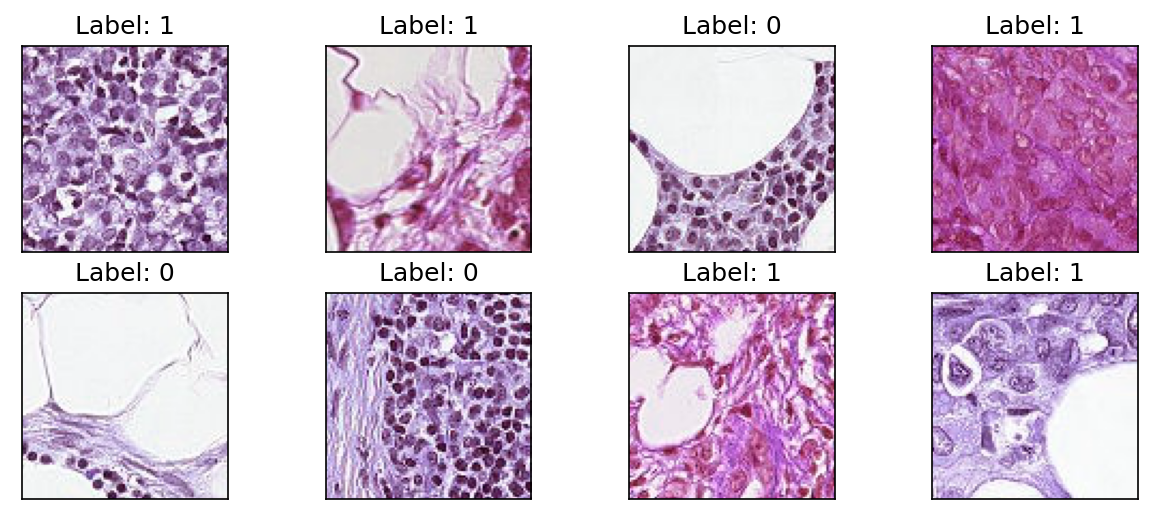

In [ ]:
# Plot some images with their labels
fig = plt.figure(figsize=(10, 4), dpi=150)
np.random.seed(100) #we can use the seed to get a different set of random images
for plotNr,idx in enumerate(np.random.randint(0,N,8)):
    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx]) #plot image
    ax.set_title('Label: ' + str(y[idx])) #show the label corresponding to the image


Text(0, 0.5, '# of samples')

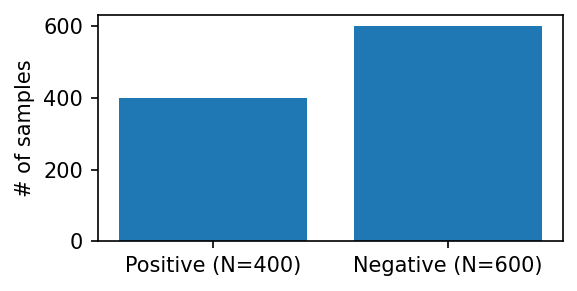

In [ ]:
# see the distribution of classes
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); #plot a bar chart of the label frequency
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (N={})".format((y==1).sum())]);
plt.ylabel("# of samples")


In [ ]:
def plot_color_histogram(X):

  # Lets look at each class individually
  positive_samples = X[y == 1]
  negative_samples = X[y == 0]

  nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
  fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

  #RGB channels
  axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
  axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
  axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
  axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
  axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
  axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

  #All channels
  axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
  axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

  #Set image labels
  axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
  axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
  axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
  axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
  axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
  axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
  for i in range(4):
      axs[i,0].set_ylabel("Relative frequency")
  axs[3,0].set_xlabel("Pixel value")
  axs[3,1].set_xlabel("Pixel value")
  fig.tight_layout()

  return fig, axs

(<Figure size 1200x1200 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7eaecfb1d0>,
       dtype=object))

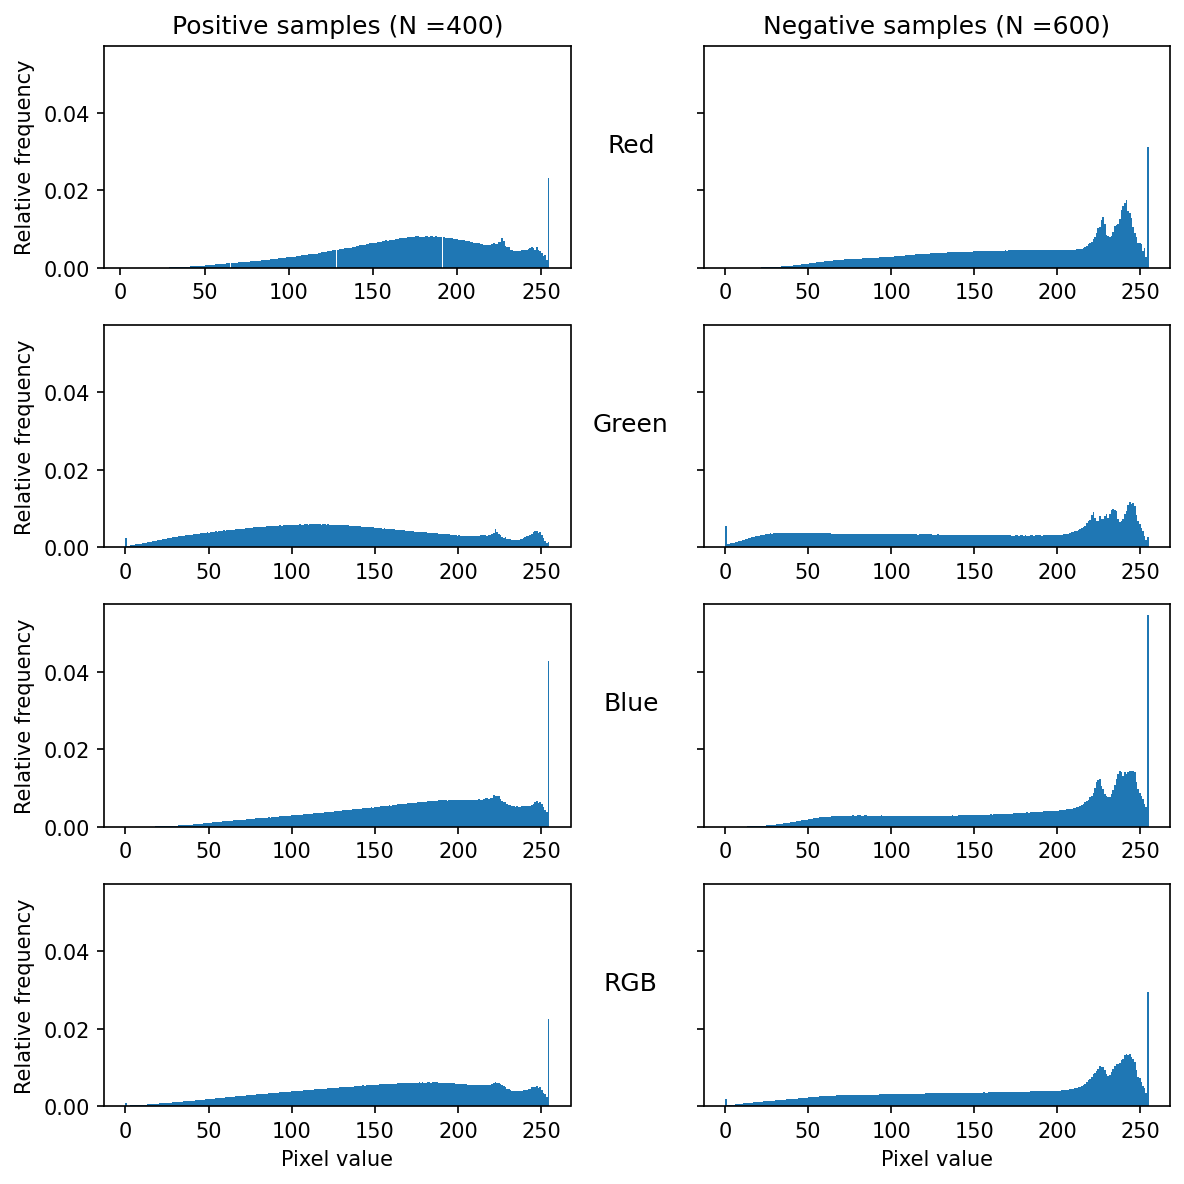

In [ ]:
# Plot the histograms
plot_color_histogram(X)

In [ ]:
# now, lets calculate the mean brightness for positives and negative samples

def plot_mean_brightnes(X):
  
  positive_samples = X[y == 1]
  negative_samples = X[y == 0]

  nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
  fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
  axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
  axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
  axs[0].set_title("Mean brightness, positive samples");
  axs[1].set_title("Mean brightness, negative samples");
  axs[0].set_xlabel("Image mean brightness")
  axs[1].set_xlabel("Image mean brightness")
  axs[0].set_ylabel("Relative frequency")
  axs[1].set_ylabel("Relative frequency");

  return fig, axs


(<Figure size 1200x300 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ead115a90>,
       dtype=object))

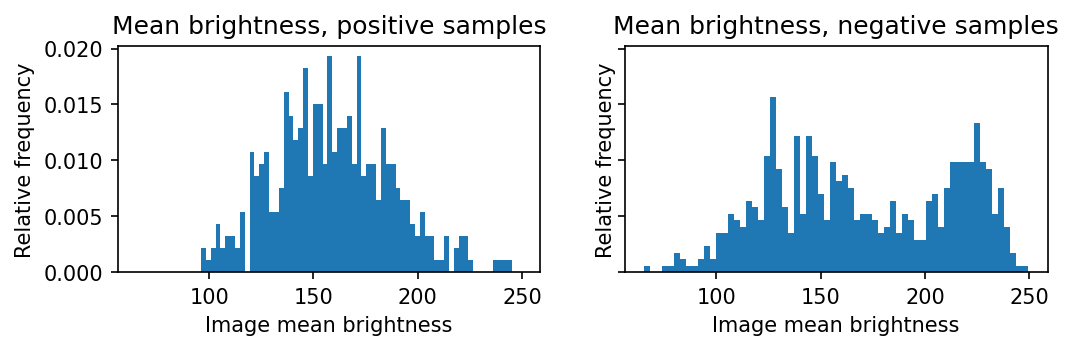

In [ ]:
plot_mean_brightnes(X)

In [ ]:
# Read function for outlier extraction

def readCroppedImage(path):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    

    #print(path) #just to see what is wrong


    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])

    return rgb_img / 255

In [ ]:
#Outlier extraction function

#Here we drop a column of the df to fit the original code
data = df.drop('path', 1)
shuffled_data = shuffle(data)

# As we count the statistics, we can check if there are any completely black or white images
dark_th = 120 / 255      # If no pixel reaches this threshold, image is considered too dark
bright_th = 135 / 255   # If no pixel is under this threshold, image is considerd too bright
too_dark_idx = []
too_bright_idx = []

x_tot = np.zeros(3)
x2_tot = np.zeros(3)
counted_ones = 0
for i, idx in tqdm(enumerate(shuffled_data['id']), 'computing statistics...(220025 it total)'):
    path = os.path.join(train_path, idx)
    imagearray = readCroppedImage(path + '.tif').reshape(-1,3)
    # is this too dark
    if(imagearray.max() < dark_th):
        too_dark_idx.append(idx)
        continue # do not include in statistics
    # is this too bright
    if(imagearray.min() > bright_th):
        too_bright_idx.append(idx)
        continue # do not include in statistics
    x_tot += imagearray.mean(axis=0)
    x2_tot += (imagearray**2).mean(axis=0)
    counted_ones += 1
    
channel_avr = x_tot/counted_ones
channel_std = np.sqrt(x2_tot/counted_ones - channel_avr**2)
channel_avr,channel_std

computing statistics...(220025 it total): 220025it [02:05, 1751.06it/s]


(array([0.70228242, 0.54550476, 0.69626777]),
 array([0.23845272, 0.2816214 , 0.21564412]))

In [ ]:
# Here we will drop the outliers from the original dataset

# Here we just assign the index to the column id
data1 = data.set_index('id')

# Drop the rows (images) that were considered outliers
no_outliers = data1.drop(labels=too_dark_idx, axis=0)
no_outliers = no_outliers.drop(labels=too_bright_idx, axis=0)


In [ ]:
#print(len(data))
len(no_outliers)

219113

In [ ]:
# merge two dataframes
#final = df1.join(df2)




In [ ]:
#train_path = 'train/'

# function to produce the training dataset

def training_dataset(train_path, no_outliers):

  df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
  df['id'] = df.path.map(lambda x: x.split('/')[1].split(".")[0]) # keep only the file names in 'id'
  df_i = df.set_index('id')
  final = pd.merge(df_i, no_outliers, left_index=True, right_index=True)
  final.reset_index(inplace=True)
  final = final.rename(columns = {'index':'id'})
  return final 









In [ ]:
no_outliers = training_dataset(train_path, no_outliers)

In [ ]:

X_out,y = load_data(N=len(no_outliers),df=no_outliers) 


100%|██████████| 219113/219113 [03:17<00:00, 1112.08it/s]


(<Figure size 1200x1200 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd41e304128>,
       dtype=object))

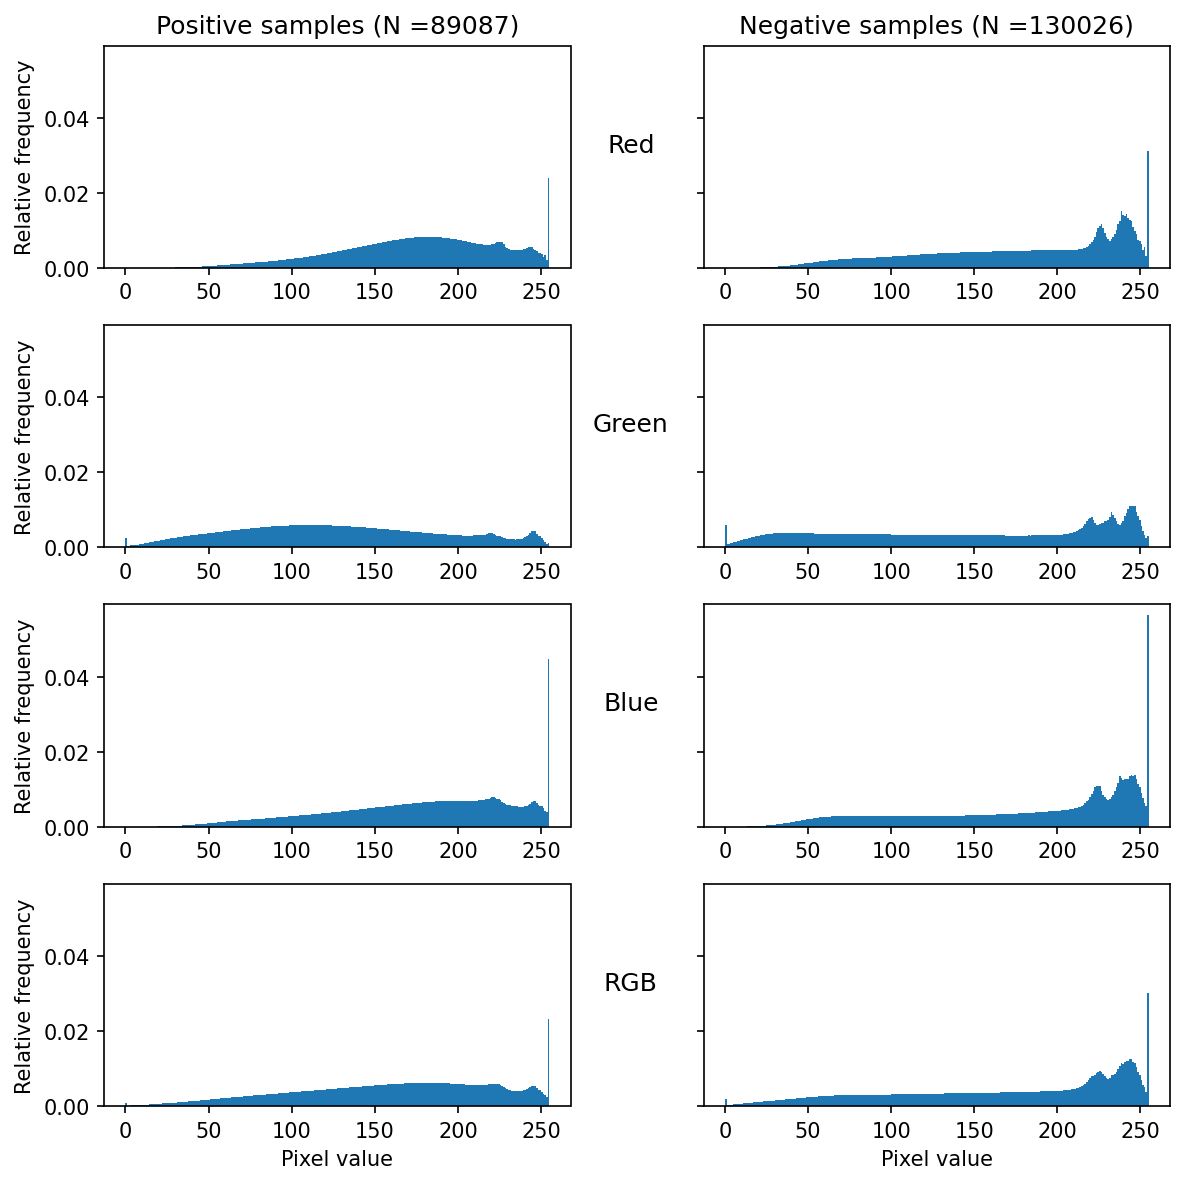

In [ ]:
# Plot color histrograms without outliers
plot_color_histogram(X_out)

(<Figure size 1200x300 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd41c9a9ef0>,
       dtype=object))

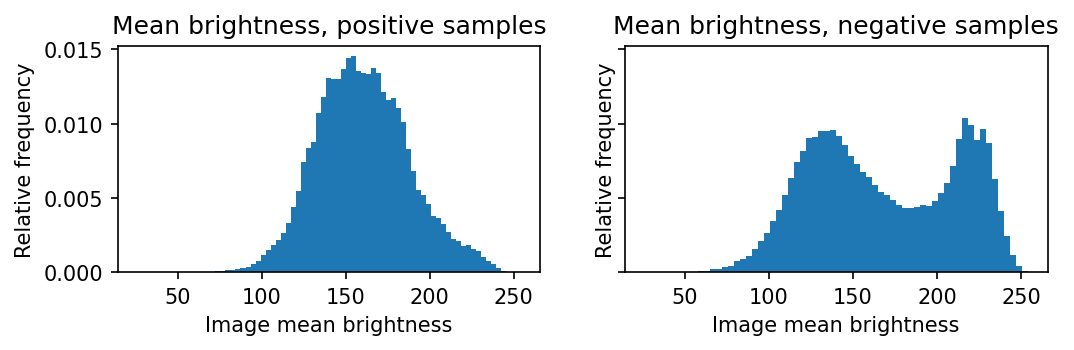

In [ ]:
#Plot mean brightness histograms without outliers
plot_mean_brightnes(X_out)